# Gerekli kütüphanelerin indirilmesi

In [100]:
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

In [101]:
!pip install transformers
!pip install zemberek-python

# Kütüphanelerin import edilmesi

In [102]:
import os
import re
import random
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import transformers
from transformers import BertTokenizer
from transformers import AdamW

from zemberek import TurkishMorphology, TurkishSentenceNormalizer

seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [103]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


# Veri setinin yüklenmesi ve analizi

In [104]:
# veri kaynağı -> https://www.kaggle.com/datasets/onurkarasoy/turkish-sms-collection
path="/content/TurkishSMSCollection.csv"
df=pd.read_csv(path, sep=';')
df.head()

,Message,Group,GroupText
0,125 lira,2,Normal
1,Baskanin aksam toplantısi fenaymis :),2,Normal
2,Bilal yalçnlara ne zaman gidiyoruz?,2,Normal
3,"BiP ile mesajlarimi aninda, daha eglenceli gon...",1,Spam
4,DIGITURKTEN FIRSAT! SiZE OZEL YIL SONUNA KADAR...,1,Spam


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4751 entries, 0 to 4750
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Message    4751 non-null   object
 1   Group      4751 non-null   int64 
 2   GroupText  4751 non-null   object
dtypes: int64(1), object(2)
memory usage: 111.5+ KB


In [106]:
df.isnull().sum()

,0
Message,0
Group,0
GroupText,0


In [107]:
df.GroupText.value_counts()

,count
GroupText,
Spam,2536
Normal,2215


In [108]:
morphology = TurkishMorphology.create_with_defaults()
normalizer=TurkishSentenceNormalizer(morphology)

INFO:zemberek.morphology.turkish_morphology:TurkishMorphology instance initialized in 19.688007354736328


2024-10-15 05:39:45,633 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 19.688007354736328



In [109]:
# verideki kelimelerin belli bir formatta dönüştürülmesi ve yazım hatalarının düzeltilmesi

df.drop("Group",axis=1,inplace=True)
df["GroupText"].replace({"Spam":1,"Normal":0},inplace=True)
df["Message"]=df["Message"].apply(lambda x: normalizer.normalize(x))
df["Message"]=df["Message"].apply(lambda x: re.sub("[^a-zıöüşçğ0-9 ]","",x))
df.head()

,Message,GroupText
0,125 lira,0
1,başkanın akşam toplantısı fenaymış,0
2,bilal yalanlara ne zaman gidiyoruz,0
3,bip ile mesajlarımı anında daha eğlenceli gön...,1
4,digitürkten fırsat size özel yıl sonuna kadar...,1


# Verilerin modele uygun formata dönüştürülmesi

In [110]:
df_0=df[df["GroupText"]==0]
df_1=df[df["GroupText"]==1]

test_0=df_0.sample(frac=0.1, random_state=seed)
test_1=df_1.sample(frac=0.1, random_state=seed)

df_0.drop(test_0.index, inplace=True)
df_1.drop(test_1.index, inplace=True)

val_0=df_0.sample(frac=0.2, random_state=seed)
val_1=df_1.sample(frac=0.2, random_state=seed)

df_0.drop(val_0.index, inplace=True)
df_1.drop(val_1.index, inplace=True)

In [111]:
train=pd.concat([df_0,df_1]).sample(frac=1, random_state=seed, ignore_index=True)
test=pd.concat([test_0,test_1]).sample(frac=1, random_state=seed, ignore_index=True)
val=pd.concat([val_0,val_1]).sample(frac=1, random_state=seed, ignore_index=True)

In [112]:
print("train: ", len(train))
print("test: ", len(test))
print("val: ", len(val))

train:  3420
test:  476
val:  855


In [113]:
print("train: ", train.GroupText.value_counts())
print("\ntest: ", test.GroupText.value_counts())
print("\nval: ", val.GroupText.value_counts())

train:  GroupText
1    1826
0    1594
Name: count, dtype: int64

test:  GroupText
1    254
0    222
Name: count, dtype: int64

val:  GroupText
1    456
0    399
Name: count, dtype: int64


In [114]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train["Message"], train["GroupText"]))
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)


val_ds = tf.data.Dataset.from_tensor_slices((val["Message"], val["GroupText"]))
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)


test_ds = tf.data.Dataset.from_tensor_slices((test["Message"], test["GroupText"]))
test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

# Kullanacağımız Bert modelinin ve preprocessing modelinin indirilmesi

Kullandığımız BERT modeli bert-en-uncased-l-2-h-128-a-2 yani ingilizce küçük harfli, 2 katmanlı, 128 gizli boyutlu ve 2 dikkat katmanlıdır.

In [115]:
# defining the URL of the smallBERT model to use
tfhub_handle_encoder = ("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-2-h-128-a-2/2")

# defining the corresponding preprocessing model for the BERT model above
tfhub_handle_preprocess = ("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected           : https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-2-h-128-a-2/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [116]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

INFO:absl:Fingerprint not found. Saved model loading will continue.


2024-10-15 05:45:42,187 - absl - INFO
Msg: Fingerprint not found. Saved model loading will continue.



INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.


2024-10-15 05:45:42,191 - absl - INFO
Msg: path_and_singleprint metric could not be logged. Saved model loading will continue.



In [117]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

INFO:absl:Fingerprint not found. Saved model loading will continue.


2024-10-15 05:45:44,147 - absl - INFO
Msg: Fingerprint not found. Saved model loading will continue.



INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.


2024-10-15 05:45:44,150 - absl - INFO
Msg: path_and_singleprint metric could not be logged. Saved model loading will continue.



# Modelin kurulması

In [118]:
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")  #input layer /giriş katmanı
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name="preprocessing")  # pre-processing layer / ön işleme katmanı
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name="BERT_encoder") # encoder layer / kodlayıcı katmanı
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net) # dropout katmanı
    net = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier")(net) # sınıfalandırma katmanı
    return tf.keras.Model(text_input, net)


dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)

INFO:absl:Fingerprint not found. Saved model loading will continue.


2024-10-15 05:45:45,629 - absl - INFO
Msg: Fingerprint not found. Saved model loading will continue.



INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.


2024-10-15 05:45:45,635 - absl - INFO
Msg: path_and_singleprint metric could not be logged. Saved model loading will continue.



INFO:absl:Fingerprint not found. Saved model loading will continue.


2024-10-15 05:45:47,445 - absl - INFO
Msg: Fingerprint not found. Saved model loading will continue.



INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.


2024-10-15 05:45:47,449 - absl - INFO
Msg: path_and_singleprint metric could not be logged. Saved model loading will continue.



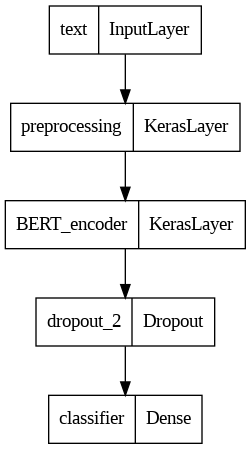

In [119]:
tf.keras.utils.plot_model(classifier_model)

In [120]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [121]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

INFO:absl:using Adamw optimizer


2024-10-15 05:45:47,606 - absl - INFO
Msg: using Adamw optimizer



INFO:absl:AdamWeightDecay gradient_clip_norm=1.000000


2024-10-15 05:45:47,610 - absl - INFO
Msg: AdamWeightDecay gradient_clip_norm=1.000000



In [122]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Modelin çalıştırlması ve sonuç

In [123]:
print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Training model with https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-2-h-128-a-2/2
Epoch 1/5
107/107 [==============================] - 15s 101ms/step - loss: 0.4065 - binary_accuracy: 0.8053 - val_loss: 0.1122 - val_binary_accuracy: 0.9626
Epoch 2/5
107/107 [==============================] - 11s 103ms/step - loss: 0.1070 - binary_accuracy: 0.9643 - val_loss: 0.0635 - val_binary_accuracy: 0.9836
Epoch 3/5
107/107 [==============================] - 11s 102ms/step - loss: 0.0660 - binary_accuracy: 0.9775 - val_loss: 0.0573 - val_binary_accuracy: 0.9860
Epoch 4/5
107/107 [==============================] - 11s 103ms/step - loss: 0.0519 - binary_accuracy: 0.9825 - val_loss: 0.0548 - val_binary_accuracy: 0.9871
Epoch 5/5
107/107 [==============================] - 11s 104ms/step - loss: 0.0463 - binary_accuracy: 0.9871 - val_loss: 0.0547 - val_binary_accuracy: 0.9871


In [124]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

15/15 [==============================] - 1s 64ms/step - loss: 0.0542 - binary_accuracy: 0.9853
Loss: 0.054248739033937454
Accuracy: 0.9852941036224365


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


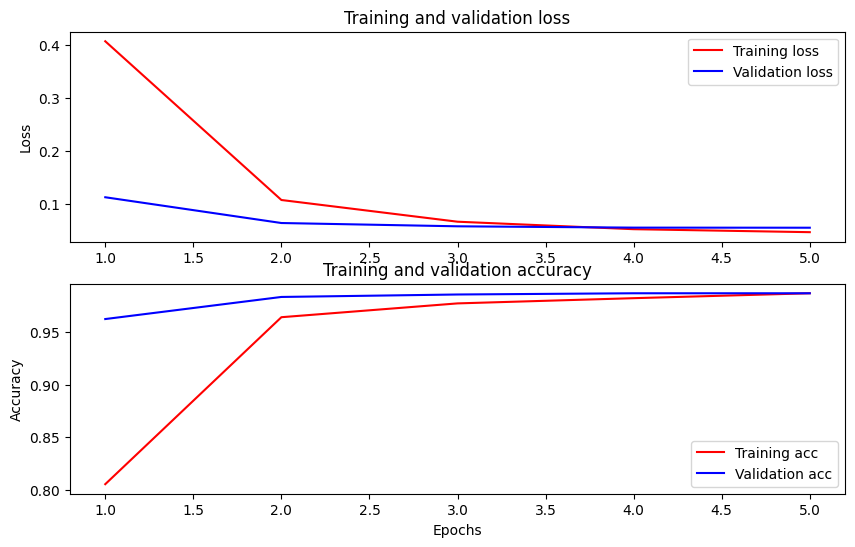

In [125]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")